In [2]:
!pip install pytorch-lightning
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 21.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-man

In [9]:
import pandas as pd

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchmetrics

from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

import pytorch_lightning as pl

sns.set_theme(style="darkgrid", palette="pastel")
sns.set_context("notebook")

from utils import train_model # you need to copy utils.py to your working directory in colab

# Histological Cancer Detection

In the real-life adventures of data scientists, acquiring and preparing the data can often be the most time-consuming part of a project.  You can use steps in Section 0 to get the data into Colab.

## Section 0 - Preparing the Data

We've center-cropped the images to 32x32 for you.  

1. Use the link in the Week 11 module to get the file histo_cropped.zip and place it in your Google Drive in the Colab Notebooks folder.  (If you working locally just get the zip file from Canvas and unzip it in your working directory).
2. The next cell will mount your Google Drive.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The next cell will copy the zip file to your Colab working directory and unzip it.  This should take about a minute.

In [6]:
!cp "/content/drive/My Drive/Colab Notebooks/histo_cropped.zip" .
!unzip -q "histo_cropped.zip"

You could probably do this with one line, but that's not important.  You should now have a folder named 'histo_cropped' with a subfolder named images and a labels.csv file.

You should always have a look at your data to make sure everything is in order.  Here's the first few rows of labels  

In [8]:
csv_file = 'histo_cropped/labels.csv'

labels = pd.read_csv(csv_file)
labels.head()

,id,label
0,d293308913e4a40cebb809d986aa9add65a76bfa,0
1,fcd55f03496afb4b11598d9c2231e86da318e723,1
2,5c983c8f14afeffdb098b9f3cbb68488a802b957,0
3,71bf03e8530348e57ec07d8ce2052f215390c997,0
4,1533406000e26663c5fadac3bcc3e38285a45bb3,1


Let's also plot 20 random images just to check them out:

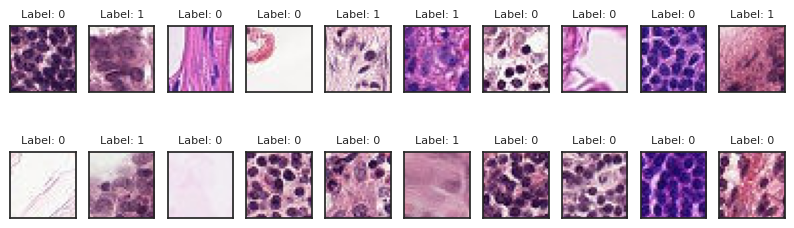

In [9]:
images_path = 'histo_cropped/images/'

sns.set_theme(style="white", palette="pastel")

# Setting seed for reproducibility
np.random.seed(0)

# Choose 20 random rows from cancer_labels
sample_cases = labels.sample(20)

# Create a figure with 20 subplots
fig = plt.figure(figsize=(10, 3))
for idx in range(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(images_path + sample_cases.iloc[idx]['id'] + '.tif')
    plt.imshow(im)
    lab = sample_cases.iloc[idx]['label']
    ax.set_title(f'Label: {lab}', fontsize = 8)

plt.show()

## Section 1 - Construct the Datasets and Loaders

First we'll load the labels.csv file into a dataframe, downsample it, and do a two or three way split to constructs dataframes for training, validation, and testing or just for training and validation.  In the next cell we introduce a 'helper' function and show how to use it in the cell after that.

In [7]:
def load_and_split_data(source_dir, csv_file_name, sample_size, proportions, seed=42):
    # Ensure the proportions sum to 1
    if not 0.99 < sum(proportions) < 1.01:
        raise ValueError("Proportions must sum to 1")

    # Load the CSV file
    source_dir = Path(source_dir)
    csv_path = csv_file_name
    df = pd.read_csv(csv_path)

    # Sample the DataFrame
    sampled_df = df.sample(n=sample_size, random_state=seed)

    # Split the DataFrame based on the proportions provided
    if len(proportions) == 3:
        # Split into train, validation, and test sets
        prop_train, prop_valid, _ = proportions
        train_df, temp_df = train_test_split(sampled_df, train_size=prop_train, random_state=seed)
        valid_df, test_df = train_test_split(temp_df, train_size=prop_valid / (1 - prop_train), random_state=seed)
        return train_df, valid_df, test_df
    elif len(proportions) == 2:
        # Split into train and test sets (valid set is not created)
        prop_train, _ = proportions
        train_df, test_df = train_test_split(sampled_df, train_size=prop_train, random_state=seed)
        return train_df, test_df
    else:
        raise ValueError("Proportions tuple must have either two or three elements")

In [10]:
data_directory = './histo_cropped'
csv_file = data_directory+'/labels.csv'

sample_size = 50000 # use None for all data
proportions = (0.8, 0.1, 0.1)  # For a three-way split
# proportions = (0.8, 0.2)  # Uncomment for a two-way split
random_seed = 42

train_df, valid_df, test_df = load_and_split_data(data_directory, csv_file, sample_size, proportions, random_seed)
# For a two-way split, use:
# train_df, test_df = load_and_split_data(data_directory, csv_file, sample_size, proportions, random_seed)

### Make a custom dataset class

In [11]:
class CancerDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        """
        Args:
            dataframe (pandas.DataFrame): DataFrame with 'id' and 'label'.
            root_dir (string): Root directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.images_dir = os.path.join(root_dir, 'images')  # Folder containing images

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Construct the full path to the image
        img_name = f"{self.dataframe.iloc[idx]['id']}.tif"
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path)
        label = np.float32(self.dataframe.iloc[idx]['label'])

        if self.transform:
            image = self.transform(image)

        return image, label

### Choose Transforms

The transforms for the validation and test datasets should just be converting to tensors and normalization.  You can add data augmentation transforms to the the training transforms:

In [12]:
original_mean = [0.5,0.5,0.5]
original_std = [0.5,0.5,0.5]

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(), ## add more if desired
    transforms.Normalize(mean = original_mean, std = original_std)
])

valid_transform = transforms.Compose([
        transforms.ToTensor(), # Converts to Tensor and scales pixels between 0 and 1
        transforms.Normalize(mean = original_mean, std = original_std)
    ])

test_transform = valid_transform

### Instantiate the datasets

In [13]:
train_dataset = CancerDataset(train_df, data_directory, train_transform)
valid_dataset = CancerDataset(valid_df, data_directory, valid_transform)
test_dataset = CancerDataset(test_df, data_directory, test_transform)

### Build the Dataloaders

In [14]:
B = 200
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=B, shuffle=False)
test_loader = DataLoader(valid_dataset, batch_size=B, shuffle=False)

### Train the first CNN

In [15]:
def ConvBlock(in_chan, out_chan, kernel_size = 5, stride = 1, pad = 2, leak_rate=0.1):
    block = nn.Sequential(
        nn.Conv2d( in_chan, out_chan, kernel_size, stride, pad),
        nn.MaxPool2d(2),
        nn.LeakyReLU(leak_rate)
    )
    return block

def ClassificationHead1H(in_chan, hidden_chan, num_outputs, leak_rate=0.1):
    head = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_chan, hidden_chan),
        nn.LeakyReLU(leak_rate),
        nn.Dropout(0.5),
        nn.Linear(hidden_chan, num_outputs)
    )
    return head


class FirstCNN(nn.Module):
    '''
    Two convolution layers.  One output class for BCELossWithLogits
    '''
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32,64),
            ConvBlock(64,128),
            ClassificationHead1H(128*4*4,500,1)
        )

    def forward(self, x):
        return(self.layers(x).squeeze())

In [16]:
model = FirstCNN()
loss_function = nn.BCEWithLogitsLoss()
num_epochs=15

metrics = {'accuracy': torchmetrics.Accuracy(task='binary'),}

firstcnn_results_df = train_model(model, loss_function,
                         epochs = num_epochs,
                         metrics = metrics,
                         train_loader = train_loader,
                         val_loader = valid_loader)

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 15/15, Training 100.00% complete, Validation 100.00% complete lr = 1.000e-03
 Epoch  train_accuracy  train_loss  val_accuracy  val_loss      Time    LR
    11        0.834900    0.379283        0.8364  0.375606 57.479818 0.001
    12        0.837850    0.375290        0.8372  0.385195 56.328111 0.001
    13        0.840475    0.366901        0.8370  0.380140 55.615544 0.001
    14        0.844550    0.359207        0.8434  0.373776 57.598898 0.001
    15        0.847275    0.355277        0.8250  0.406969 55.398592 0.001


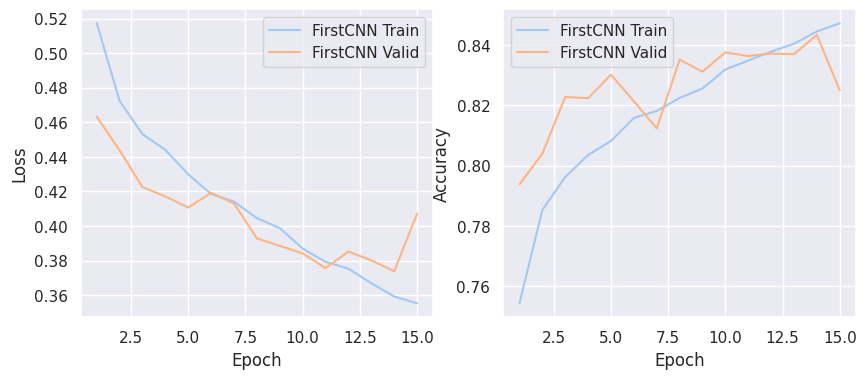

In [17]:
def make_plots(label_df_dict):
    fig,ax = plt.subplots(1,2,figsize=(10,4))
    for label,df in label_df_dict.items():
        sns.lineplot(x='Epoch',y='train_loss',data=df,label=f'{label} Train',ax=ax[0]);
        sns.lineplot(x='Epoch',y='val_loss',data=df,label=f'{label} Valid',ax=ax[0]);
        ax[0].set_ylabel('Loss')
    for label,df in label_df_dict.items():
        sns.lineplot(x='Epoch',y='train_accuracy',data=df,label=f'{label} Train',ax=ax[1]);
        sns.lineplot(x='Epoch',y='val_accuracy',data=df,label=f'{label} Valid',ax=ax[1]);
        ax[1].set_ylabel('Accuracy')


results_dict = {'FirstCNN':firstcnn_results_df} # can add more dataframes in this dict to compare results
make_plots(results_dict)